This notebook loads tif files from a 'confinement' experiment, fits the data to obtain a diffusion coefficient. 

In [1]:
#!pip3 install pims trackpy

In [1]:
import sys 

from matplotlib import rcParams 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from pandas import DataFrame, Series  # for convenience 
 
import pims 
import trackpy as tp

In [5]:
# former path
path='/home/pkh-lab-shared/ekrueger2/microscopy_data/Confinement/confinement_data_11_14_22/'
# new path (rsync'd a local copy)
# rsync -ah /home/echo_nfs/microscopy_data/11_14_22_confinement/confinement_data_11_14_22 $KAFKA:/u1/pkekeneshuskey/delme/
path='/u1/pkekeneshuskey/delme/confinement_data_11_14_22/'
treatment=['11']
    
#density = ['A']
#fld = ['1','2','3'] 
#ATPno = ['1','2'] 

# with atp? 
# they're from the experiments on 12/12/22. here is the pathway for that folder: /home/ekrueger2/echo_drive/12_12_22_confinement/confinement_data_12_12_22
# they're named based on being confined/unconfined and ATP/noATP


In [6]:
filenames_confinement = [] 
 
for condition in treatment:
    filenames_confinement.append('Capture1-'+condition+'_XY0_Z0_T000_C0.tif')
    
#for dens in density: 
    #for f in fld: 
        #for ATP in ATPno: 
            #filenames_confinement.append(dens+ATP+'_fld'+f+'.tiff') 

In [7]:
frames = [] 
 
for filename in filenames_confinement: 
    frame = pims.open(path+filename) 
    frames.append(frame) 
     
print(len(frames))

1


In [8]:
v = np.array( frame ) 
print( np.shape(v) )

frame_i=v[:,:,:]
frames=[]
frames.append(frame_i)

print( np.shape(frame_i) )


(420, 1104, 1104)
(420, 1104, 1104)


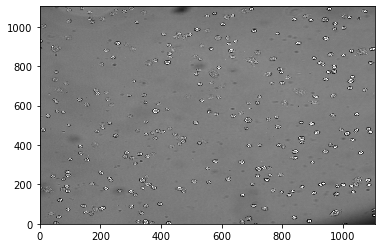

In [9]:
plt.pcolormesh( np.flipud( frame_i[0,:,:] ), cmap='gray')

In [10]:
#help( tp.batch )

Frame 419: 174 features


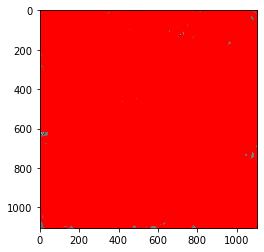

In [11]:
fb = [] 
#rcParams['figure.figsize']=10,10 
for i in np.arange(len(frames)): 
    diameter=41
    f = tp.batch(frames[i], diameter, minmass=1e2) # dunno what '39' is
    tp.annotate(f, frames[i][0]) 
    fb.append(f)

In [12]:
rcParams['figure.figsize']=7,7 


firstCell = None
maxDist=45 # maximum displacement in pixel 
maxMissFrame=200 # do not forget disappeared particles unless they've dis
msd = [] 
for j,f in enumerate(fb): 
    t = tp.link(f, maxDist, memory=maxMissFrame) 
    t1 = tp.filter_stubs(t,50) 
    d = tp.compute_drift(t1) 
    tm = tp.subtract_drift(t1.copy(), d) 
    em = tp.emsd(tm, 1.63, 1/30) 
     
     
    if j == 0: 
        time1 = [] 
        for i in em.index: 
            time1.append(i) 
         
        data = [] 
        for i in em.values: 
            data.append(i) 
        firstCell = np.array( data )
        
    else: 
         
        data_new = [] 
        for i in em.values: 
            data_new.append(i) 
             
        data = np.asarray(data)+np.asarray(data_new) 
        
        
        

Frame 419: 174 trajectories present.


[  91.6297179   130.45712687  168.75136046  203.40143583  237.71797119
  266.81198369  298.4882838   324.40494724  346.4144938   370.25719538
  393.10904032  417.66655982  442.34920912  461.10260521  481.12193276
  504.88463963  524.93415847  548.48176441  564.52940922  587.62199511
  607.73428165  631.2134289   643.93221704  670.01052563  676.17256223
  705.14343294  729.02257014  737.77532219  758.14079472  773.88726573
  787.11863111  810.16443195  834.1254264   853.50431855  860.87541155
  880.9993926   906.52032461  926.57404514  949.06802042  964.49016393
  985.9168435   998.80548546 1014.55953495 1039.10693067 1044.15615554
 1071.2534868  1088.53294094 1120.24958213 1140.20702457 1151.51054372
 1179.26033937 1197.05265477 1219.37373606 1234.34243204 1247.43587731
 1270.75472187 1294.04262784 1276.35005858 1324.77489496 1331.63105214
 1326.75811886 1348.32901497 1370.36854426 1381.92693946 1398.56451984
 1414.33363195 1442.28665456 1454.17081329 1476.17154189 1485.91488665
 1517.

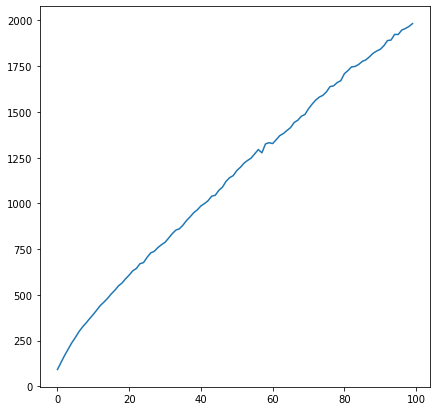

In [13]:
print(firstCell)
plt.plot( firstCell )

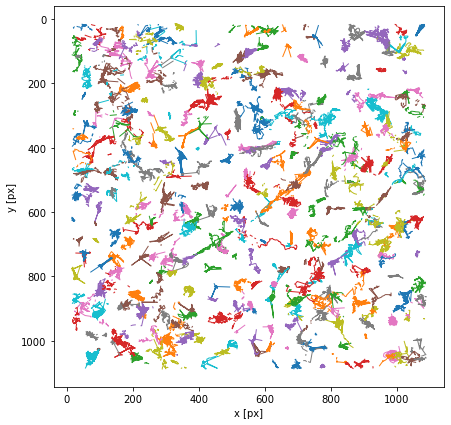

In [14]:
tp.plot_traj(t1)

In [15]:
v = np.asarray( data )
print(np.shape(v))
data = v

(100,)


In [16]:
print("NEED TO FIX, this is not a good way of doing this")
numTraj = len(frames)
dataavg1=data/numTraj


NEED TO FIX, this is not a good way of doing this


In [17]:
from scipy import stats 
res1 = stats.linregress(time1,dataavg1) 
print(f"R-squared: {res1.rvalue**2:.6f}") 
print("Slope: ",res1.slope) 
print("Intercept: ",res1.intercept)

R-squared: 0.996388
Slope:  0.6132925425224705
Intercept:  203.91675322698893


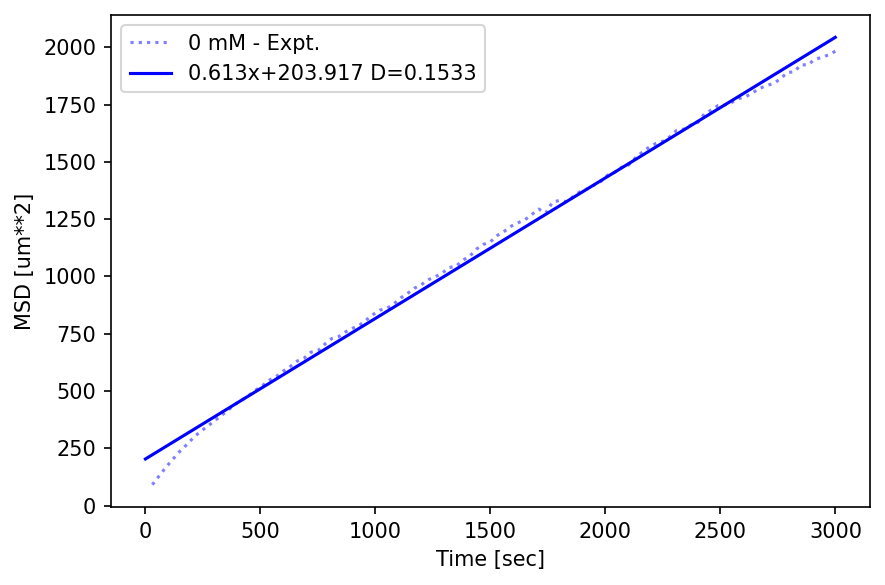

In [18]:
x1 = np.arange(3000)
plt.figure(figsize=(6,4),dpi=150)
plt.plot(time1,dataavg1,'b:',alpha=0.5,label='0 mM - Expt.')
plt.plot(x1,res1.intercept + res1.slope*x1,'b',
         label=str('%.3f'%(res1.slope))+"x+"+str('%.3f'%(res1.intercept))+' D='+str('%.4f'%(res1.slope/4)))

plt.legend(loc=0)
plt.xlabel('Time [sec]')
plt.ylabel('MSD [um**2]')
plt.tight_layout()

In [54]:
print(time1[-1])

3000.0
